Actual dataset columns: ['img', 'title', 'console', 'genre', 'publisher', 'developer', 'critic_score', 'total_sales', 'na_sales', 'jp_sales', 'pal_sales', 'other_sales', 'release_date', 'last_update']
Normalized dataset columns: ['img', 'title', 'console', 'genre', 'publisher', 'developer', 'critic_score', 'total_sales', 'na_sales', 'jp_sales', 'pal_sales', 'other_sales', 'release_date', 'last_update']
Final dataset columns: ['img', 'title', 'platform', 'genre', 'publisher', 'developer', 'critic_score', 'global_sales', 'na_sales', 'jp_sales', 'eu_sales', 'other_sales', 'release_date', 'last_update', 'year']
                        MSE      RMSE       MAE  R² Score
Linear Regression  0.000048  0.006901  0.005272  0.999991
Random Forest      0.281834  0.530880  0.223853  0.946963
XGBoost            0.224524  0.473839  0.206330  0.957748


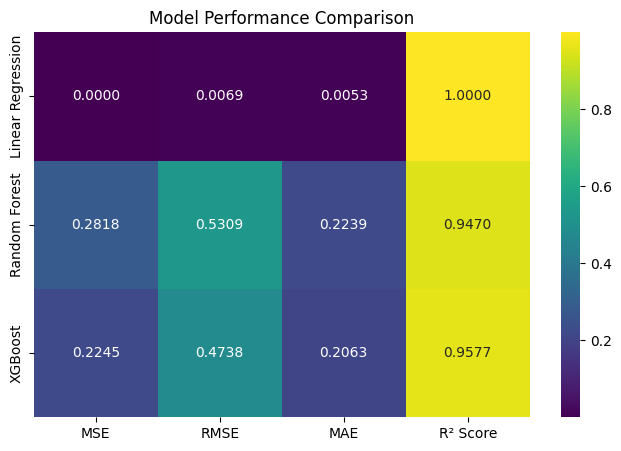

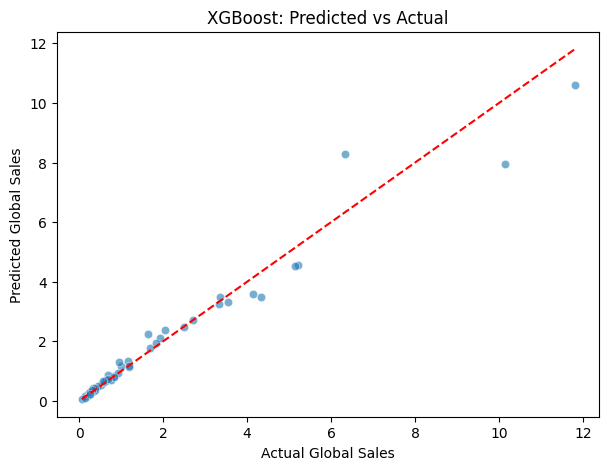

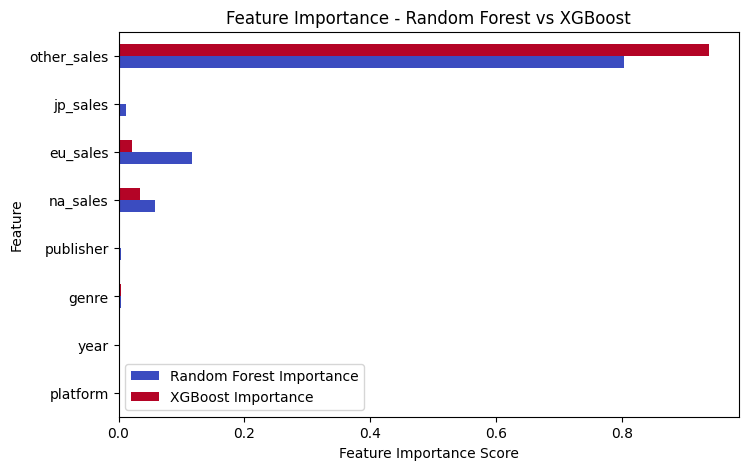

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


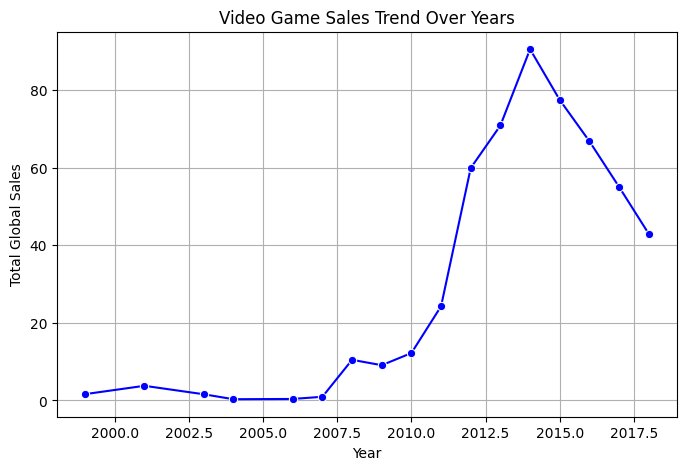

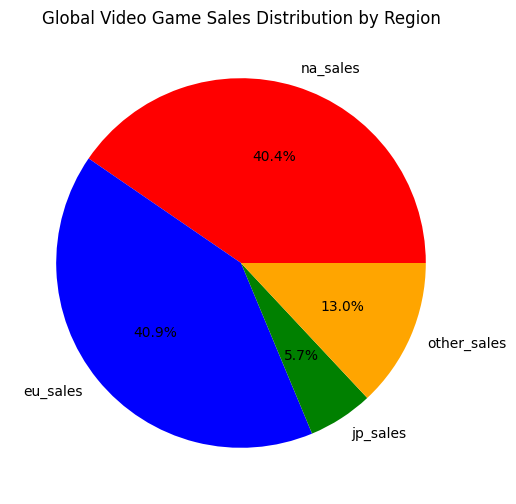

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load dataset
df = pd.read_csv("/kaggle/input/video-game-sales-2024/vgchartz-2024.csv")

# Print actual column names before processing
print("Actual dataset columns:", df.columns.tolist())

# Normalize column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
print("Normalized dataset columns:", df.columns.tolist())

# Manually adjust column names
df.rename(columns={
    'console': 'platform',  
    'pal_sales': 'eu_sales',  
    'total_sales': 'global_sales',  
}, inplace=True)

# Extract year from release_date
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['year'] = df['release_date'].dt.year

# Verify final column names
print("Final dataset columns:", df.columns.tolist())

# Check required columns
required_columns = ['platform', 'year', 'genre', 'publisher', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'global_sales']
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise KeyError(f"Missing columns in dataset: {missing_columns}")

# Drop rows with missing values
df.dropna(inplace=True)

# Encoding categorical features
le = LabelEncoder()
df['platform'] = le.fit_transform(df['platform'])
df['genre'] = le.fit_transform(df['genre'])
df['publisher'] = le.fit_transform(df['publisher'])

# Selecting features and target
features = ['platform', 'year', 'genre', 'publisher', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales']
target = 'global_sales'

X = df[features]
y = df[target]

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Applying Machine Learning Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

# Training and Evaluating Models
model_results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store results
    model_results[name] = {"MSE": mse, "RMSE": rmse, "MAE": mae, "R² Score": r2}

# Convert results into DataFrame for visualization
results_df = pd.DataFrame(model_results).T
print(results_df)

# 📊 1. Heatmap for Model Performance
plt.figure(figsize=(8, 5))
sns.heatmap(results_df, annot=True, cmap="viridis", fmt=".4f")
plt.title("Model Performance Comparison")
plt.show()

# 📉 2. Scatter Plot - Predicted vs. Actual (for XGBoost)
y_pred_xgb = models["XGBoost"].predict(X_test)
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="dashed")
plt.xlabel("Actual Global Sales")
plt.ylabel("Predicted Global Sales")
plt.title("XGBoost: Predicted vs Actual")
plt.show()

# Feature Importance - Random Forest
rf_importances = models["Random Forest"].feature_importances_

# Feature Importance - XGBoost
xgb_importances = models["XGBoost"].feature_importances_

# Convert to DataFrame
feature_imp_df = pd.DataFrame({
    "Feature": features,
    "Random Forest Importance": rf_importances,
    "XGBoost Importance": xgb_importances
}).set_index("Feature")

# 📊 3. Feature Importance Comparison
feature_imp_df.plot(kind="barh", figsize=(8, 5), colormap="coolwarm")
plt.xlabel("Feature Importance Score")
plt.title("Feature Importance - Random Forest vs XGBoost")
plt.show()

# Sales Trend Over Years
yearly_sales = df.groupby("year")["global_sales"].sum()

# 📈 4. Sales Trend Over Years
plt.figure(figsize=(8, 5))
sns.lineplot(x=yearly_sales.index, y=yearly_sales.values, marker="o", color="blue")
plt.xlabel("Year")
plt.ylabel("Total Global Sales")
plt.title("Video Game Sales Trend Over Years")
plt.grid()
plt.show()

# 📊 5. Regional Sales Pie Chart
region_sales = df[["na_sales", "eu_sales", "jp_sales", "other_sales"]].sum()

plt.figure(figsize=(6, 6))
region_sales.plot(kind="pie", autopct="%1.1f%%", colors=["red", "blue", "green", "orange"])
plt.title("Global Video Game Sales Distribution by Region")
plt.ylabel("")  # Hide y-axis label
plt.show()
